You have to change the path in the next code block

In [1]:
import os
os.chdir(os.path.expanduser('~/programming/python/phyper/example'))

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_iris

import h5py
import numpy as np

from config import instances, Instance
from dataset import Iris
from paths import get_cross_validation_scores_path, get_training_metrics_path
from IPython.display import display
from paths import jupyter_plot
# orca has been installed with `brew cask install orca`
plotly.io.orca.config.executable = '/usr/local/Caskroom/orca/1.3.1/orca.app/Contents/MacOS/orca'

In [3]:
data = load_iris()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target
# print(df)

In [4]:
from score_models import get_last_epoch

all_scores = pd.DataFrame(columns=['instance_hash', 'training_loss', 'training_accuracy', 'validation_loss', 'validation_accuracy'])
rows = []
for instance in instances:
    path = get_training_metrics_path(instance)
    with h5py.File(path, 'r') as f5:
        keys = f5.keys()
        last_epoch = get_last_epoch(keys)
        metrics = f5[f'epoch{last_epoch}']
        training_loss = metrics['training_loss']
        training_accuracy = metrics['training_accuracy']
        validation_loss = metrics['validation_loss']
        validation_accuracy = metrics['validation_accuracy']
        rows.append({'instance_hash': instance.get_instance_hash(),
                     'training_loss': metrics['training_loss'][...].item(),
                     'training_accuracy': metrics['training_accuracy'][...].item(),
                     'validation_loss': metrics['validation_loss'][...].item(),
                     'validation_accuracy': metrics['validation_accuracy'][...].item()})
all_scores = all_scores.append(rows, ignore_index=True)
all_scores.sort_values(by=['instance_hash'], inplace=True)
cv_scores = pd.read_csv(get_cross_validation_scores_path())
models = Instance.get_resources(instances, resource_name='cross_validated_model')

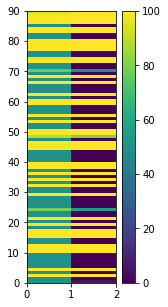

In [5]:
plt.figure(figsize=(2, 5))
# plt.pcolor(all_scores[['training_loss', 'validation_loss']])
plt.pcolor(all_scores[['training_accuracy', 'validation_accuracy']])
plt.colorbar()
plt.show()

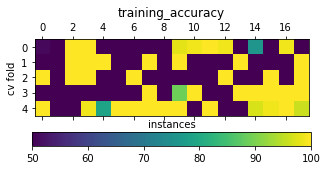

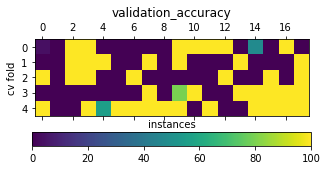

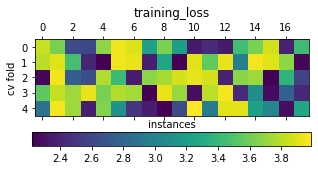

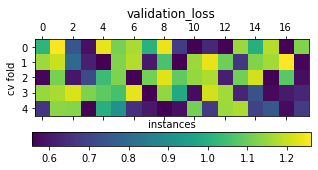

In [6]:
def f(column_name):
    column = all_scores[[column_name]]
    v = column.to_numpy()
    m = v.reshape((-1, instance.cv_k)).transpose()
    plt.figure(figsize=(5, 2))
    plt.matshow(m, fignum=0)
    plt.colorbar(orientation='horizontal')
    plt.title(column_name)
    plt.xlabel('instances')
    plt.ylabel('cv fold')
    plt.show()

f('training_accuracy')
f('validation_accuracy')
f('training_loss')
f('validation_loss')

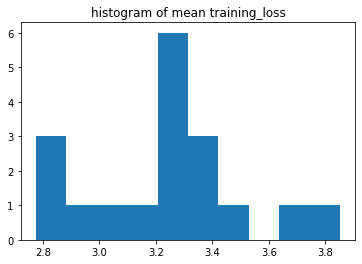

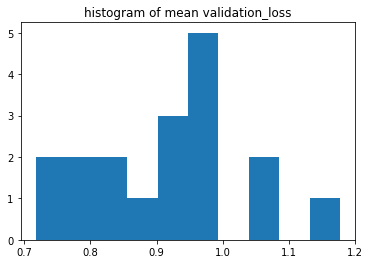

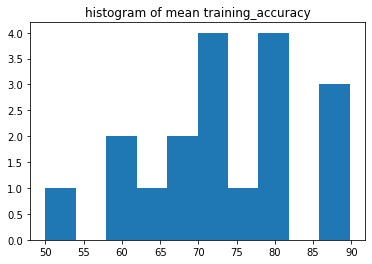

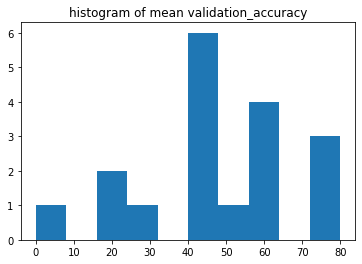

In [7]:
def g(column_name):
    m = all_scores[[column_name]].to_numpy().reshape((-1, instance.cv_k))
    means = np.mean(m, axis=1)

    plt.figure()
    plt.hist(means)
    plt.title('histogram of mean ' + column_name)
    plt.show()

g('training_loss')
g('validation_loss')
g('training_accuracy')
g('validation_accuracy')

In [8]:
parallel_df = all_scores.copy()
parallel_df.set_index(keys=['instance_hash'], inplace=True)
parallel_df['transformation'] = None
parallel_df['centering'] = None
parallel_df['n_hidden_layers'] = None
transformations = {}
for instance in instances:
    instance_hash = instance.get_instance_hash()
    parallel_df.at[instance_hash, 'transformation'] = instance.transformation
    parallel_df.at[instance_hash, 'centering'] = instance.centering
    parallel_df.at[instance_hash, 'n_hidden_layers'] = instance.n_hidden_layers

In [9]:
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.express as px

fig = px.parallel_coordinates(parallel_df[['training_loss', 'validation_loss', 'training_accuracy', 'validation_accuracy']], color='validation_accuracy', color_continuous_scale=px.colors.diverging.Tealrose, title='Relation between losses and accuracies')
fig.update_layout(
    autosize=False,
    width=1600,
    height=800
)
plotly.offline.iplot(fig)

In [22]:
parallel_df.sort_values(by=['validation_accuracy', 'n_hidden_layers'], ascending=False, inplace=True)
df = px.data.tips()
fig = px.parallel_categories(parallel_df, dimensions=['transformation', 'centering', 'n_hidden_layers', 'validation_accuracy'],
                color='validation_accuracy', color_continuous_scale=px.colors.sequential.Inferno,
                labels={'transformation': 'Transformation', 'centering': 'Centering', 'n_hidden_layers': '# hidden layers', 'validation_accuracy': 'Validation accuracy'},
                title='Effect of the hyperparameters on validation accuracy')
fig.update_layout(
    autosize=False,
    width=1600,
    height=800
)
fig.write_image(jupyter_plot('parallel_categories.png'))
fig.show()

In [11]:
import plotly.graph_objects as go
p_df = parallel_df.copy()
transformation_k = list(set(parallel_df['transformation'].tolist()))
transformation_v = list(range(len(transformation_k)))
transformation_d = dict(zip(transformation_k, transformation_v))
p_df['transformation'] = p_df['transformation'].apply(lambda x: transformation_d[x])
p_df['centering'] = p_df['centering'].apply(lambda x: int(x))

# display(p_df.head(10))
# for x in p_df.iloc[0]:
#     print(type(x), x)

In [21]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = p_df['validation_accuracy'],
            colorscale = 'Viridis',
            showscale = True,
            cmin = p_df['validation_accuracy'].min(),
            cmax = p_df['validation_accuracy'].max()),
        dimensions = list([
            dict(range = [min(transformation_v), max(transformation_v)],
                 tickvals = transformation_v,
                 ticktext = transformation_k,
                 label = 'Transformation', values = p_df['transformation'].tolist()),
            dict(range = [0, 1],
                 tickvals = [0, 1],
                 ticktext = ['No', 'Yes'],
                 label = 'Centering', values = p_df['centering'].tolist()),
            dict(range = [p_df['n_hidden_layers'].min(), p_df['n_hidden_layers'].max()],
                 tickvals = p_df['n_hidden_layers'].unique().tolist(),
                 label = '# hidden layers', values = p_df['n_hidden_layers'].tolist()),
            dict(range = [p_df['training_accuracy'].min(), p_df['training_accuracy'].max()],
                 label = 'Training accuracy', values = p_df['training_accuracy'].tolist()),
            dict(range = [p_df['validation_accuracy'].min(), p_df['validation_accuracy'].max()],
                 label = 'validation accuracy', values = p_df['validation_accuracy'].tolist()),
            dict(range = [p_df['training_loss'].min(), p_df['training_loss'].max()],
                 label = 'Training loss', values = p_df['training_loss'].tolist()),
            dict(range = [p_df['validation_loss'].min(), p_df['validation_loss'].max()],
                 label = 'validation loss', values = p_df['validation_loss'].tolist()),
            # dict(range = [1,5],
            #      tickvals = [1,2,4,5],
            #      label = 'C', values = [2,4],
            #      ticktext = ['text 1', 'text 2', 'text 3', 'text 4']),
            # dict(range = [1,5],
            #      label = 'D', values = [4,2])
        ])
    )
)
fig.update_layout(
    template='plotly_dark',
    title='Effect of the hyperparameters on validation accuracy',
    autosize=False,
    width=1600,
    height=800
)

fig.show()